### Test where we generate virtual shot gathers along line 2EW, which is perpendicular to the road

#### We might assume that the channel closest to the road should act as a virtual source of surface waves when a car is passing by

Again, this is based on the work of Dou et al. (2017). The aim is to identify times when cars pass the array by exloring the quality of the EGFs produced by stacking of the data. We might then be able to use the dispersion characteristics to to predict soil moisture variation

<img src="DAS_image1.png" alt="Drawing" style="width: 500px;"/>

<img src="DAS_image_3.png" alt="Drawing" style="width: 500px;"/>

In [1]:
import glob
import os
import numpy as np
import obspy as op
from obspy.signal.cross_correlation import correlate
import pandas as pd
import matplotlib.pyplot as plt
from ts_tools import spectralWhitening, despike 
%matplotlib inline

In [2]:
def whiten(trace):
    
    tr = trace.copy()
    w_dat = spectralWhitening(trace.data)
    tr.data = w_dat
    
    return tr

In [3]:
os.chdir("/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict")

In [4]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineEW = all_data[all_data['Line'] == "Line2EW"][['file_name','DateTime']]
#In this experiment we're only interested in the file names and the times


lineEW.reset_index(drop=True,inplace=True)
#Note that to avoid warning we should use assign to replace column values
lineEW.assign(DateTime = pd.to_datetime(lineEW['DateTime']).values)
otime = op.UTCDateTime(lineEW['DateTime'][0])
lineEW.set_index('DateTime',inplace=True)

#Generate linking column
lineEW = lineEW.assign(file_name=lineEW['file_name'].apply(lambda x: x[2:]))
fnames = list(lineEW['file_name'])

In [5]:
lineEW.head()

,file_name
DateTime,
2016-08-05 18:07:38,20160805180738_40_Hz_Line2EW.mseed
2016-08-05 18:08:38,20160805180838_40_Hz_Line2EW.mseed
2016-08-05 18:09:38,20160805180938_40_Hz_Line2EW.mseed
2016-08-05 18:10:38,20160805181038_40_Hz_Line2EW.mseed
2016-08-05 18:11:38,20160805181138_40_Hz_Line2EW.mseed


In [6]:
#Location of the DAS data files
datadir = "/media/rmartinshort/My Book/4Robert"
cwd = os.getcwd()
os.chdir(datadir)

In [7]:
f = op.read(fnames[0],format='mseed')
f = f.detrend('demean')
f = f.detrend('linear')

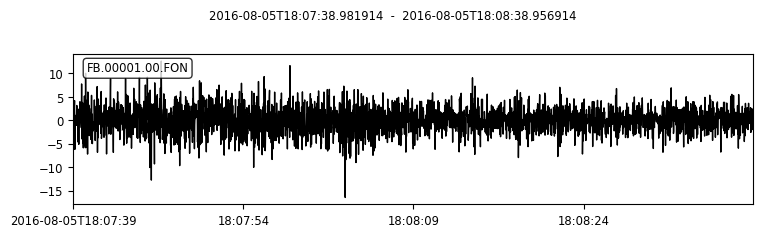

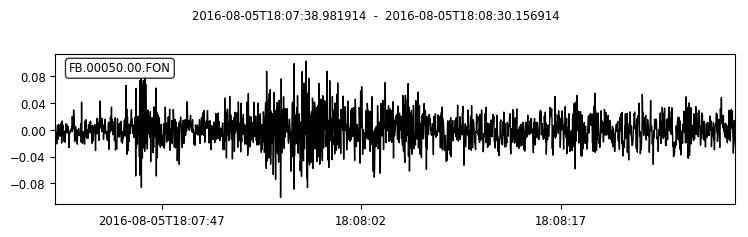

In [8]:
shift = f[0].stats.npts
nchan = len(f)

#############plot the pre-whitened trace
f[1].plot()
f0 = whiten(f[-1])

############plot the whitened trace
f0.plot()


fc = correlate(f0,f0,shift)
X = np.linspace(-60,60,2*shift+1)
Xcorr_mat = np.zeros([len(fc),nchan])
Xcorr_mat[:,0] = fc

In [9]:
for i in range(1,nchan):
    fc = correlate(f0,whiten(f[nchan-(i+1)]),shift)
    #fc = correlate(f0,f[nchan-(i+1)],shift)
    Xcorr_mat[:,i] = fc

(-1, 1)

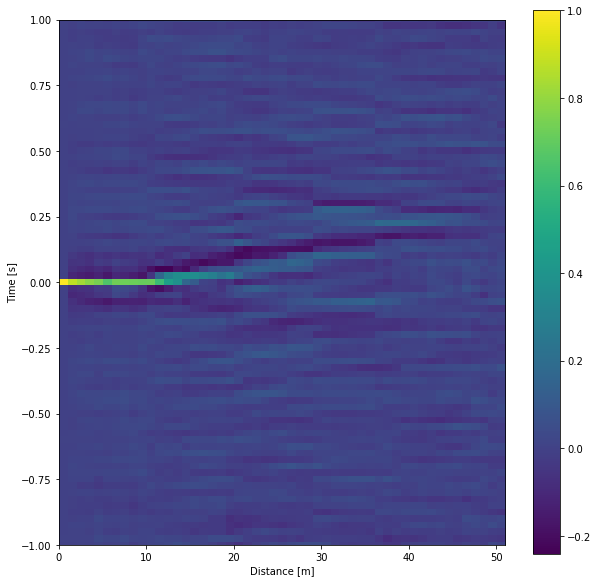

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(Xcorr_mat,aspect=30,extent=[0,nchan,-60,60],vmax=1,interpolation='nearest')
plt.colorbar()
plt.xlabel('Distance [m]')
plt.ylabel('Time [s]')
plt.ylim([-1,1])

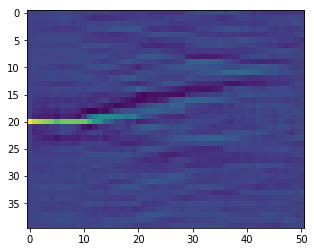

In [11]:
plt.imshow(Xcorr_mat[shift-20:shift+20,:])

#### Testing the Dou et al. 2017 QC proceedure for surface waves
>  Determine RMS amplitude as a function of channel offset from the road 

>  Fit a power law curve of the type a + b*x^(c)   

>  We would expect c to be roughly equal to -2 if there is a source of surface waves from the road   

>  Find the correlation coefficient between the power law prediction and the observation  

>  Compute abs(c*R+2). If this is larger than 1, we have a good source of surface waves  


In [12]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def func_powerlaw(x,m,c0,c1):
    
    return c0 + c1*(x**m)

target_func = func_powerlaw

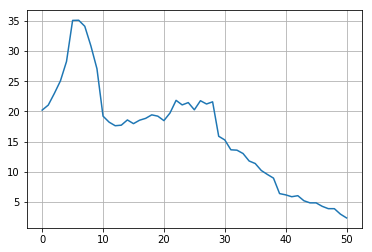

In [13]:
chan_n = np.zeros(nchan)
rms_vals = np.zeros(nchan)
for i in range(nchan):
    x = f[nchan-(i+1)].data
    rms_noise = np.sqrt(np.mean(x*x))
    chan_n[i] = i
    rms_vals[i] = rms_noise

plt.plot(chan_n,rms_vals)
plt.grid()

In [14]:
popt, pcov = curve_fit(target_func,chan_n,rms_vals)

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power


In [15]:
popt

array([ 1.5725282 , 26.18276028, -0.05373139])

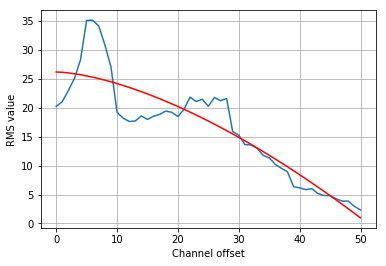

In [16]:
plt.plot(chan_n,rms_vals)
plt.plot(chan_n,target_func(chan_n,*popt),'r-')
plt.xlabel('Channel offset')
plt.ylabel('RMS value')
plt.grid()

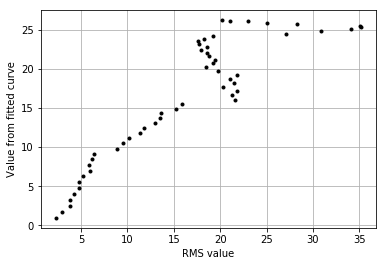

In [17]:
plt.plot(rms_vals,target_func(chan_n,*popt),'k.')
plt.xlabel('RMS value')
plt.ylabel('Value from fitted curve')
plt.grid()

In [18]:
corr_coef = pearsonr(rms_vals,target_func(chan_n,*popt))[0]
optval = abs(popt[0]*corr_coef + 2)
print(optval)

3.415893522587389
